# Mandelbrot Set Part 3 - GPU Programming

In [1]:
import numpy as np
import pyopencl as cl
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import os

os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"

## OpenCL Implementation

#### Kernel Explaination
The kernel is made to take pointers to a complex mesh called C_buff, and a uint8 array called results_buff to store the results in.

Furthermore it takes arguments for max_iters and threshold as const values.

The kernel gets the id of the current work item (or pixel), that it is operating on and uses it to access the correct value in the complex mesh, as well as store the result correctly in the output array.

It initializes z as a complex datatype as $z = 0 + j0$, and creates an intermediate variable for the z_squared value.

It is important that the complex mesh and the output array is flattened, as they are indexed as a 1D vector.

The complex mesh and the output array are both kept in global memory, and passed as pointers, as these need to be accessed by all work items. While this is also the case for the threshold, and the max_iters. These variables are checked frequently for comparison in the mandelbrot set, so they are kept locally in constant memory for faster access.

The rest of the variables are private, as they are only used internally inside the individual work items.

In [2]:
def mandelbrot_gpu(C, max_iters, threshold, pl_id):
    # opencl setup
    platforms = {"CPU": 0, "GPU": 1}
    platform = cl.get_platforms()[platforms[pl_id]]  # platform (CPU or GPU)
    device = [platform.get_devices()[0]]

    ctx = cl.Context(devices=device)
    queue = cl.CommandQueue(ctx)

    # prepare mesh grid and output
    C_flat = np.complex64(C.flatten())
    mset = np.zeros(C_flat.shape, dtype=np.int32)

    # create buffers for mesh and output
    mf = cl.mem_flags  # shortcut to use memory flags
    C_buff = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=C_flat)  # copy to host device
    mset_buff = cl.Buffer(ctx, mf.WRITE_ONLY, mset.nbytes)  # create buffer with size of mset in bytes

    # define kernel
    mandelbrot_kernel = """
    #include <pyopencl-complex.h>
    __kernel void compute_mandelbrot(
        __global const cfloat_t *C_buff,
        __global int *mset_buff,
        const int max_iters,
        const float threshold
        )
    {
        int gid = get_global_id(0);
        cfloat_t z = cfloat_new(0.0f, 0.0f);
        cfloat_t zsq;
        
        cfloat_t C = cfloat_new(C_buff[gid].real, C_buff[gid].imag);
        uint iter = 0;

        while(iter < max_iters){
            zsq = cfloat_mul(z, z);
            z = cfloat_add(zsq, C);
            float abs_z = cfloat_abs(z);
            if (abs_z > threshold) {
                break;
            }
            iter++;
        }
        mset_buff[gid] = iter;
    }
    """
    
    # create program
    program = cl.Program(ctx, mandelbrot_kernel)
    program.build()

    # run program on chosen device
    program.compute_mandelbrot(
        queue,
        (C_flat.size,),
        None,  # local size None, auto-determine
        C_buff,
        mset_buff,
        np.uint32(max_iters),  # Use uint32 for max_iters
        np.float32(threshold)  # Use float32 for threshold
    )
    
    # copy results back from device
    cl.enqueue_copy(queue, mset, mset_buff)

    # reshape mset back into array shape
    mset = np.reshape(mset, C.shape)

    return mset


def create_mesh(re_min, re_max, im_min, im_max, p_re, p_im):
    re = np.linspace(re_min, re_max, p_re, dtype=np.complex64)
    im = np.linspace(im_min, im_max, p_im, dtype=np.complex64)
    C = re[np.newaxis, :] + 1j * im[:, np.newaxis] # create axis across columns for real part and rows for imaginary part
    
    return C

c:\Users\clyho\miniconda3\envs\opencl-env\Lib\site-packages\pyopencl\cache.py:496: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'gfx1010:xnack-' on 'AMD Accelerated Parallel Processing' at 0x1db472ada90> succeeded, but said:

1 warning generated.

  _create_built_program_from_source_cached(


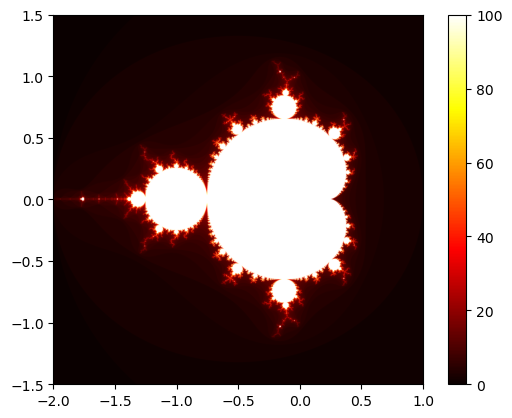

In [3]:
p_re = 5000 # number of points in the real part
p_im = 5000 # number of points in the imaginary part
re_min, re_max = -2.0, 1.0
im_min, im_max = -1.5, 1.5
max_iters = 100
threshold = 2

C = create_mesh(re_min, re_max, im_min, im_max, p_re, p_im)
mset = mandelbrot_gpu(C, max_iters, threshold, "GPU")
plt.imshow(mset, extent=[re_min, re_max, im_min, im_max])
plt.set_cmap('hot')
plt.colorbar()
plt.show()